In [1]:
!pip install pyyaml h5py  # Required to save models in HDF5 format

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip install kaggle
!mkdir /root/.kaggle
import json
token = {"username":"oliverxie","key":"27eb35f64a866446390a5b0d714b6dfe"}
with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)
!chmod 600 /root/.kaggle/kaggle.json
!kaggle config set -n path -v{/content}
!kaggle datasets download "borismarjanovic/price-volume-data-for-all-us-stocks-etfs" -p /content
!unzip -q -n \*.zip 

mkdir: cannot create directory ‘/root/.kaggle’: File exists
- path is now set to: {/content}
price-volume-data-for-all-us-stocks-etfs.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
!ls ETFs/tecl.us.txt

ETFs/tecl.us.txt


In [5]:
%tensorflow_version 2.x
import pandas as pd
import numpy as np
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Saving Path

In [0]:
pth = 'drive/My Drive/532m_saves'
pth += '/cnn-ns-5d-vggm2-sgd_lr0001'

In [0]:
# import os
# pth = "training_1/cp.ckpt"
# dir = os.path.dirname(pth)


# Generate Dataset

In [7]:
d = pd.read_csv('ETFs/tecl.us.txt')
d.head()
d = d.iloc[:,1:-2]

print(d.shape)
d.head()

(2241, 4)


,Open,High,Low,Close
0,2.8140,2.9930,2.7992,2.9048
1,2.7795,2.8457,2.5638,2.6448
2,2.7870,2.8432,2.6985,2.7330
3,2.7280,2.7280,2.3992,2.4630
4,2.6250,2.6372,2.4532,2.4925


In [0]:
def generate_rnn_dataset(array, window_size, prediction_size, offset):
    n_samples = len(array) - window_size - prediction_size - offset
    X = np.ndarray([n_samples, window_size, array.shape[1]])
    y = np.ndarray([n_samples, prediction_size, array.shape[1]])
    for i in range(n_samples):
        X[i,:] = array[i:i+window_size]
        st_pos = i+window_size + 1 + offset
        y[i] = array[st_pos: st_pos + prediction_size]

    return (X, y)

In [9]:
d_np = d.to_numpy()


# from sklearn import preprocessing
# transformer = preprocessing.StandardScaler()
# d = transformer.fit_transform(d)

X, y = generate_rnn_dataset(d_np, 100, 5, 0)
y = y[:,:,3,np.newaxis]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)

print(X.shape)
print(y.shape)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(2136, 100, 4)
(2136, 5, 1)
(1602, 100, 4) (1602, 5, 1)
(534, 100, 4) (534, 5, 1)


# Model

In [10]:
from functools import partial 
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from keras.regularizers import l1_l2
from tensorflow.keras.layers import (
    Conv1D, Flatten, MaxPooling1D, Dense, BatchNormalization, 
    Reshape, Dropout
)

Conv1D = partial(
    Conv1D, padding='same', 
    activation='relu',
    # kernel_regularizer=l1_l2(1e-3, 1e-3),
)

model = Sequential()

def pattern(n_filters, input_shape=None):
    if input_shape is None:
        model.add(Conv1D(n_filters, kernel_size=3))
    else:
        model.add(Conv1D(n_filters, kernel_size=3, input_shape=input_shape))
    model.add(Conv1D(n_filters, kernel_size=3))
    model.add(MaxPooling1D(2))
    # model.add(Dropout(0.5))
    model.add(BatchNormalization())

pattern(64, input_shape=X.shape[1:])
pattern(128)
pattern(256)
pattern(512)
# pattern(512)
# pattern(512)


model.add(Flatten())
model.add(Dense(200))

n_output = y.shape[1:]
print(n_output)
model.add(Dense(np.prod(n_output)))
model.add(Reshape(target_shape=n_output))


model.build()
# model.summary()

Using TensorFlow backend.


(5, 1)


In [0]:
from tensorflow.keras.optimizers import SGD
model.compile(optimizer=SGD(lr=0.0001, momentum=0.1), loss='mse')
# model.compile(optimizer="adam", loss='mse')
# model.compile(optimizer='nAdam', loss='mse')

from tensorflow.keras.callbacks import ModelCheckpoint
mc = ModelCheckpoint(pth+'-best_model.h5',
                     monitor='val_loss', mode='min', save_best_only=True,
                    #  verbose=True,
                     )

# Training

In [12]:
history = model.fit(
    x=X_train, y=y_train,
    batch_size=128, epochs=100,
    validation_data=(X_test, y_test),
    callbacks=[mc]
)

Epoch 1/100
13/13 [==============================] - 1s 106ms/step - loss: 273.3145 - val_loss: 891.7067
Epoch 2/100
13/13 [==============================] - 0s 14ms/step - loss: 19.4089 - val_loss: 950.6245
Epoch 3/100
13/13 [==============================] - 0s 15ms/step - loss: 17.7595 - val_loss: 968.4469
Epoch 4/100
13/13 [==============================] - 0s 14ms/step - loss: 9.2884 - val_loss: 988.4417
Epoch 5/100
13/13 [==============================] - 0s 14ms/step - loss: 10.4353 - val_loss: 996.0773
Epoch 6/100
13/13 [==============================] - 0s 15ms/step - loss: 14.8925 - val_loss: 997.7964
Epoch 7/100
13/13 [==============================] - 0s 15ms/step - loss: 6.0872 - val_loss: 998.2360
Epoch 8/100
13/13 [==============================] - 0s 15ms/step - loss: 9.8276 - val_loss: 999.6760
Epoch 9/100
13/13 [==============================] - 0s 15ms/step - loss: 8.6435 - val_loss: 979.7445
Epoch 10/100
13/13 [==============================] - 0s 15ms/step - loss: 

# Save results

In [13]:
print(model)

In [0]:
model.load_weights(pth +'-best_model.h5')

(2136, 5, 1)


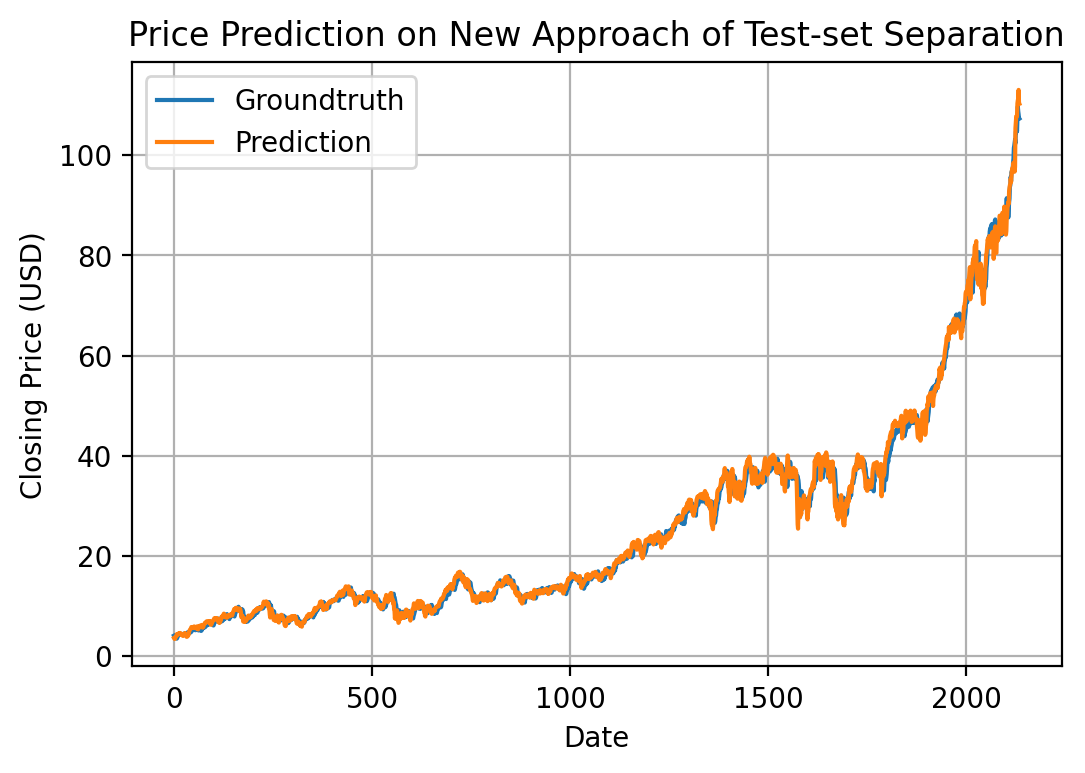

In [15]:
import matplotlib.pyplot as plt



def pl(y, y_pred):
    plt.plot(y, label='Groundtruth')
    plt.plot(y_pred, label='Prediction')
    plt.legend()
    plt.grid(True)

y_pred = model.predict(X)
y = y

print(y_pred.shape)

def get_i(i):
    return y_pred[:,i, 0], y[:,i, 0]


plt.figure(figsize=[6,4],
           dpi=200
           )
pl(*get_i(4))



# plt.plot(y_train, label='Groundtruth')
# plt.plot(model.predict(X_train), label='Training')
# plt.plot(model.predict(X_test), label='Testing')
title = "Price Prediction on New Approach of Test-set Separation"
plt.title(title)
plt.xlabel('Date')
plt.ylabel('Closing Price (USD)')
plt.show()

In [0]:
# np.save(pth+'-predict', model.predict(X))
# np.save(pth+'-true', y)

np.save(pth+'-train_loss', history.history['loss'])
np.save(pth+'-test_loss', history.history['val_loss'])


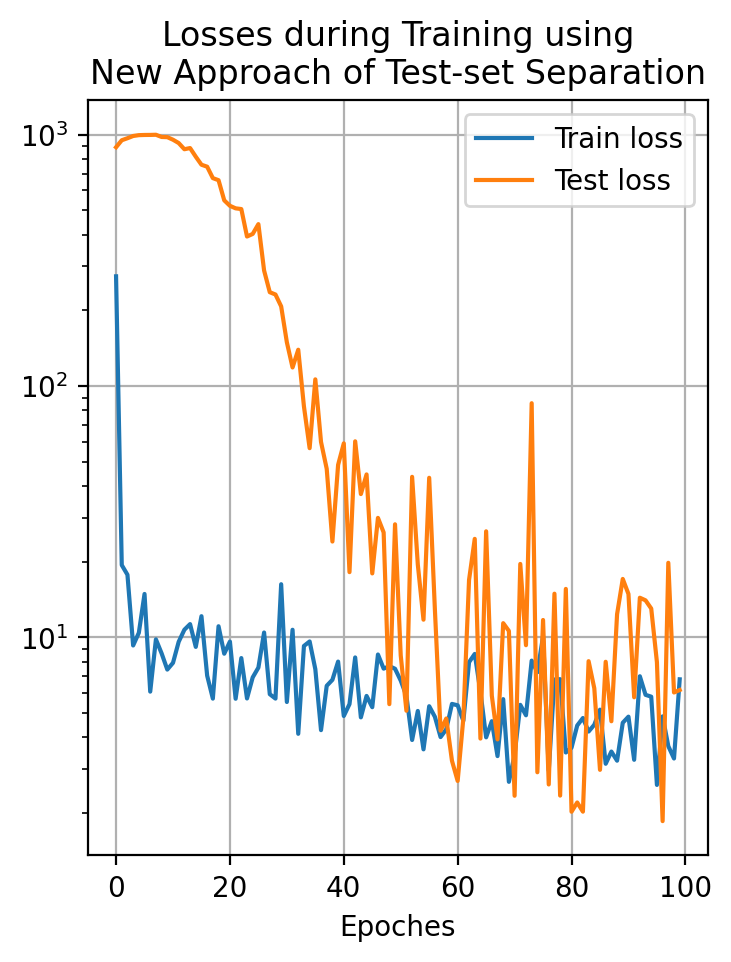

In [17]:
train_loss = np.load(pth+'-train_loss.npy')
test_loss = np.load(pth+'-test_loss.npy')

# title = "True/Predict: CNN | 5days[5] | SGD | random split"
title = 'Losses during Training using\nNew Approach of Test-set Separation'

plt.figure(figsize=[4,5], 
           dpi=200
           )

plt.semilogy(train_loss, label='Train loss')
plt.semilogy(test_loss, label='Test loss')
plt.legend()
plt.grid(True)
plt.title(title)
plt.xlabel('Epoches')
plt.show()

# plt.plot(train_loss, label='train loss')
# plt.plot(test_loss, label='test loss')
# plt.legend()
# plt.grid(True)
# plt.title(title)
# plt.show()